['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
Points 

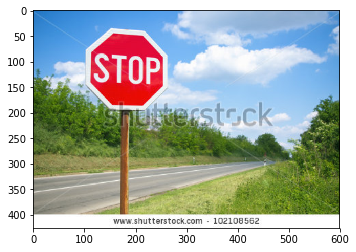

In [26]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
from scipy import misc

%matplotlib inline

# the backgorunds
background_images = []
test_images = []
BACKGROUND_DIR = './backgrounds/'
TEST_DIR = './test_images/'

TEST_IMG_W = 600

for fname in listdir(BACKGROUND_DIR):
    img = misc.imread(BACKGROUND_DIR + fname)
    background_images.append(img)

for fname in listdir(TEST_DIR):
    img = misc.imread(TEST_DIR + fname)
    prop = TEST_IMG_W / img.shape[1]
    img = misc.imresize(img, (int(img.shape[0] * prop), int(img.shape[1] * prop)))
    test_images.append(img)
    
plt.imshow(test_images[3])


# the imageset
df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    df = pd.concat([df, df_csv])
    

label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        label_names.append(row[1])

del label_names[0]
class_id_set = range(len(label_names))        

print (label_names)
print ('Points in set:', len(df))


In [27]:
W = 32
H = 32
selected = df[df['ClassId'] == 14]
sign_list = []
for i in range(len(selected)):
    img = misc.imread(selected.iloc[i]['Path'] + selected.iloc[i]['Filename'])
    sign_list.append(misc.imresize(img, (H,W)))

print ('Number of sign images:', len(sign_list))

Number of sign images: 780


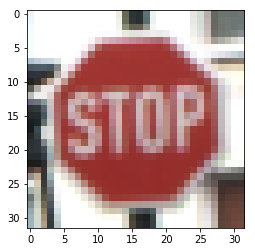

In [28]:
plt.imshow(sign_list[50])

In [29]:
import random
non_sign_list = []
i = 0
while i < len(sign_list):
    img = background_images[i % len(background_images)]
    y = random.randint(0,img.shape[0] - H)
    x = random.randint(0,img.shape[1] - W)
    cropped = img[y:y+H, x:x+W]
    non_sign_list.append(cropped)
    i += 1

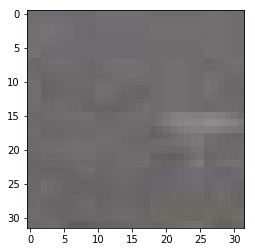

In [30]:
plt.imshow(non_sign_list[505])

(324,) (32, 32)


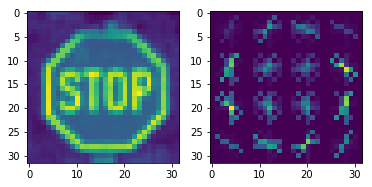

In [31]:
from skimage.feature import hog
import cv2

def hog_features(img):
    vec, hog_img = hog(img, visualise=True)
    return vec, hog_img

def features_from_img(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,1]
    vec, hogs = hog_features(img)
    return vec

img = sign_list[150]
img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,1]

vec, hogs = hog_features(img)

print (vec.shape, hogs.shape)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)

plt.imshow(hogs)

In [32]:
sign_features = [features_from_img(img) for img in sign_list]
non_sign_features = [features_from_img(img) for img in non_sign_list]

In [33]:
X = sign_features + non_sign_features
y = [1 for i in range(len(sign_features))] + [0 for i in range(len(non_sign_features))]

print(len(X), len(y))

1560 1560


In [34]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
clf.predict([features_from_img(non_sign_list[100])])
clf.score(X,y)

0.96346153846153848

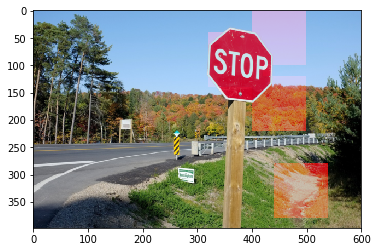

In [73]:
from skimage import draw

def slide_window(img, wsize = 100, step = 0.4):
    boxes = []
    y = 0
    while (y < img.shape[0] - wsize): 
        x = 0
        while (x < img.shape[1] - wsize):
            #box = img[y : y + wsize, x : x + wsize]
            box = (y, x, y + wsize, x + wsize)
            boxes.append(box)
            x += int(wsize * step)
        y += int(wsize * step)
    
    return boxes

def crop(img, coords):
    y1, x1, y2, x2 = coords
    return img[y1:y2, x1:x2]

image = np.copy(test_images[4])

b = slide_window(image)
boxes = [crop(image, coords) for coords in b]
preds = clf.predict([features_from_img(misc.imresize(img, (W,H))) for img in boxes])
indices = [i for i,pred in enumerate(preds) if pred == 1]

for i in indices:
    y1, x1, y2, x2 = b[i]
    rr, cc = draw.polygon([y1, y1, y2, y2], [x1, x2, x2, x1])
    image[rr, cc,0] = 200

plt.imshow(image)

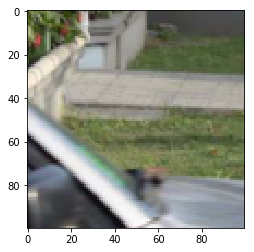